In [12]:
#Importar las librerias

import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from scipy import ndimage
from skimage.filters import threshold_otsu
from skimage.color import rgb2hed
from skimage import morphology
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from skimage import data, exposure, img_as_float
from skimage import io, color, filters
from skimage import util
from skimage import measure
from skimage.morphology import watershed, black_tophat

raiz='40X' #directorio raiz



In [13]:
#listar imagenes

def listar(de):
    #Variable para la ruta al directorio
    path = de
 
    #Lista vacia para incluir los ficheros
    name = []
 
    #Lista con todos los ficheros del directorio:
    lstDir = os.walk(path)   #os.walk() Lista directorios y ficheros
    #Crea una lista de los ficheros png que existen en el directorio y los incluye a la lista.
    i=0
    for root, dirs, files in lstDir: # recorre el direcctorio sacando los datos de las carpetas
        for fichero in files:
            (nombreFichero, extension) = os.path.splitext(fichero)
            if(extension == ".png"):
                name.append(nombreFichero)
        i += 1
        if i >= 1:
            break # rompe el ciclo para poder sacar solamente lo de la carpeta principal
    return name

def conver1(val):
    sol=(0.00377957517575*val) #formula para transformar de micras a pixeles 1° prueba
    return sol

def conver2(val, raiz):
    sol=0
    if(raiz=='20X'):
        sol=(52.16*val)/(1608/5.5)
    if(raiz=='40X'):
        sol=(70.06*val)/(1608/3)
    return sol

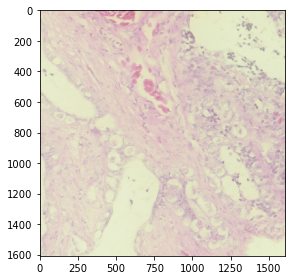

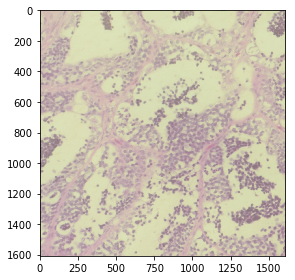

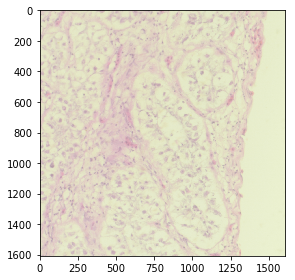

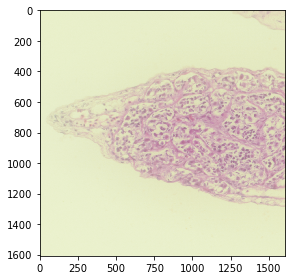

In [16]:
#linealizacion

path='raiz'#directorio de trabajo

name = listar(raiz) # entra a la funcion para sacar los archivos .png

shutil.rmtree(raiz+"/linealizacion") #eliminar directorio
os.mkdir(raiz+"/linealizacion") #crear directorio

for i in range(len(name)):
    img = io.imread(raiz+"/"+name[i]+'.png')  #leer Imagen 
    
    histo=exposure.histogram(img[:, :, 0]) #histograma de R

    a=histo[1].min() #valor minimo del histograma
    a1=histo[1].max() #valo maximo del histograma

    histo=exposure.histogram(img[:, :, 1]) #histograma de G

    b=histo[1].min() #valor minimo del histograma
    b1=histo[1].max() #valor maximo del histograma

    histo=exposure.histogram(img[:, :, 2]) #histograma de B

    c=histo[1].min() #valor minimo del histograma
    c1=histo[1].max() #valor maximo del histograma

    # parametros para las metricas de la linealizacion de histograma de acuerdo al tipo de imagen
    
    if(path=='10X'):
        img[:, :, 0]= exposure.rescale_intensity(img[:, :, 0], in_range=(a1-(1*a), a1)) # 10X=1 / 20X=0.4 / 40x=0.7
        img[:, :, 1]= exposure.rescale_intensity(img[:, :, 1], in_range=(b1-(2*b), b1))   # 10X=2 / 20X=1   / 40x=1.2
        img[:, :, 2]= exposure.rescale_intensity(img[:, :, 2], in_range=(c1-(4.5*c), c1))   # 10X=4.5 / 20X=12   / 40x=4
    
    if(path=='20X'):
        img[:, :, 0]= exposure.rescale_intensity(img[:, :, 0], in_range=(a1-(0.4*a), a1)) # 10X=1 / 20X=0.4 / 40x=0.7
        img[:, :, 1]= exposure.rescale_intensity(img[:, :, 1], in_range=(b1-(1*b), b1))   # 10X=2 / 20X=1   / 40x=1.2
        img[:, :, 2]= exposure.rescale_intensity(img[:, :, 2], in_range=(c1-(12*c), c1))   # 10X=4.5 / 20X=12   / 40x=4

    if(path=='40X'):
        img[:, :, 0]= exposure.rescale_intensity(img[:, :, 0], in_range=(a1-(0.7*a), a1)) # 10X=1 / 20X=0.4 / 40x=0.7
        img[:, :, 1]= exposure.rescale_intensity(img[:, :, 1], in_range=(b1-(1.2*b), b1))   # 10X=2 / 20X=1   / 40x=1.2
        img[:, :, 2]= exposure.rescale_intensity(img[:, :, 2], in_range=(c1-(2*c), c1))   # 10X=4.5 / 20X=12   / 40x=4
    
    io.imshow(img) # imprimir imagen
    io.show()
    
    io.imsave(raiz+'/linealizacion/'+name[i]+'_linealize_hist.png',(img)) #guardar la imagen con linealizado

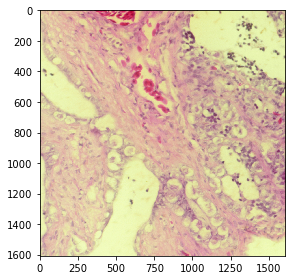

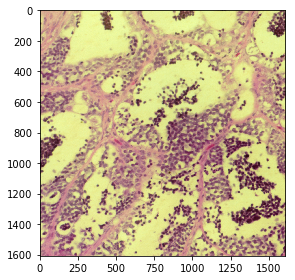

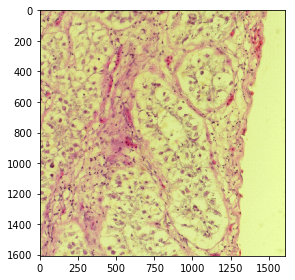

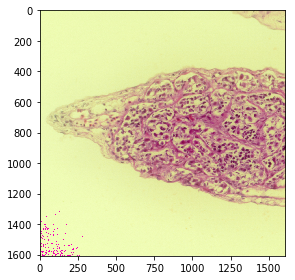

In [19]:
# Expansión de contraste

path = raiz+'/linealizacion' #directorio local de trabajo

name = listar(path) #llama funcion para listar los archivos .png en el directorio
shutil.rmtree(raiz+"/normalizacion") #eliminar directorio
os.mkdir(raiz+"/normalizacion") #crear directorio
for i in range(len(name)):
    img = io.imread(path+"/"+name[i]+'.png')
    dat = np.array(img)+.0
    sol = np.empty_like(img) #matriz de ceros

    #formula de Expansión de contraste (255*(imagen-min))/(max-min)

    sol = np.divide(np.multiply(256,np.subtract(img,img.min(),dtype=float),dtype=float),np.subtract(img.max(),img.min(),dtype=float),dtype=float)

    sol = np.uint8(sol) #de Numpy a uint8
    io.imshow(sol) #imprimir imagen
    io.show()

    io.imsave(raiz+'/normalizacion/'+name[i]+'_norma.png',(sol)) #guardar la imagen normalizada

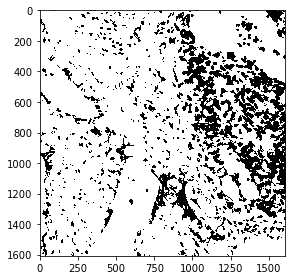

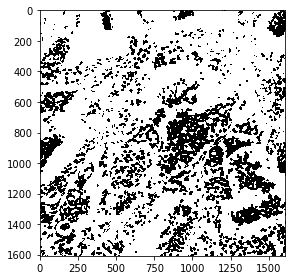

In [21]:
#Hematoxilina - Eosina

path = raiz+'/normalizacion' #directorio de trabajo local

name = listar(path) #listar los archivos .png en el directorio
shutil.rmtree(raiz+"/binario") #eliminar directorio
os.mkdir(raiz+"/binario") #crear directorio
for i in range(len(name)):
    ihc_rgb = io.imread(path+"/"+name[i]+'.png')
    ihc_hed = rgb2hed(ihc_rgb) #de RGB a HED (hematoxilina, eosina, dao)
    ihc_hed_np = np.array(ihc_hed) # de Numpy a uint8

    th = threshold_otsu(ihc_hed_np[:,:,0])
    sol = ihc_hed_np[:,:,0] <= th
    
    io.imshow(sol)
    io.show()
    
    sol = np.array(sol*255)
    
    io.imsave(raiz+'/binario/'+name[i]+'_bin.png',(np.uint8(sol))) #guardar la imagen con binarizado

In [5]:
# dice

path = raiz+'/binario' #directorio de imagenes binarias
pathb = raiz+'/grantrue' #directorio de grantrue

name = listar(path) #listar los archivos .png en el directorio
dbase = listar(pathb) #listar los archivos .png en el directorio

for i in range(len(name)):
    base = io.imread(pathb+"/"+dbase[i]+'.png')  #leer Imagen Gran True
    img = io.imread(path+"/"+name[i]+'.png')  #leer Imagen Binarizado
    base = np.divide(base,255)
    img = np.divide(img,255)

    A = np.array(base)
    B = np.array(img)
    
    dice = np.sum(B[A==1])*2/(np.sum(A)+np.sum(B))
    print(dice)

0.905627699636
0.931084135386


In [10]:
#whatershep
path = raiz+'/binario' #directorio de imagenes binarias
name = listar(path) #listar los archivos .png en el directorio

try:
    import cPickle as pickle  
except ImportError:  
    import pickle 

f = open(raiz+'.txt','w')

f.write('nombre,identificador,area,perimetro,centroide,eccentricity,euler_number,equivalent_diameter'+'\n')

for i in range(len(name)):
    
    image = io.imread(path+"/"+name[i]+'.png')  #leer Imagen
    image = util.invert(image)
    image = np.logical_or(image,0)
    
    distance = ndimage.distance_transform_edt(image)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
    
    markers = morphology.label(local_maxi)
    local_ws = watershed(-distance, markers, mask=image)
    
    #labeling

    label = util.invert(np.divide(local_ws,255))

    all_labels = measure.label(label)
    blobs_labels = measure.label(label, background=255)
    label_img = measure.label(label, connectivity=label.ndim)
    
    #Crear y leer archivos
    
    prop=regionprops(local_ws) #lista de objetos cada objeto con n atributos de forma
    for j in range(len(prop)):
        f.write(str(name[i]+'.png')+','+str(j)+','+str(conver2(prop[j].area,raiz))+','+str(conver2(prop[j].perimeter,raiz))+','+str(prop[j].centroid)+','+str(conver2(prop[j].eccentricity,raiz))+','+str(conver2(prop[j].euler_number,raiz))+','+str(conver2(prop[j].equivalent_diameter,raiz))+'\n')

f.close()